In [1]:
import re
from joblib import dump, load

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import log_loss

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nuke2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nuke2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nuke2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('data/air_tweet_train.csv', names=['Sentiment', 'Tweet'])
df

,Sentiment,Tweet
0,-1,@SouthwestAir good thing we noticed because sh...
1,1,@united They let us know in advance of the reb...
2,-1,"@USAirways sucks. Delayed my mom's flight 2X, ..."
3,-1,@united can you DM me? Been on hold with custo...
4,1,@AmericanAir THANK YOU FOR ALL THE HELP! :P Y...
...,...,...
13874,0,@JetBlue with 3 kids and 11 days 340 + doesn't...
13875,1,"@AmericanAir LTALJX, from DCA to OMA this morn..."
13876,-1,@AmericanAir I can't work with them if the cal...
13877,-1,@AmericanAir 2 months and still no exec platin...


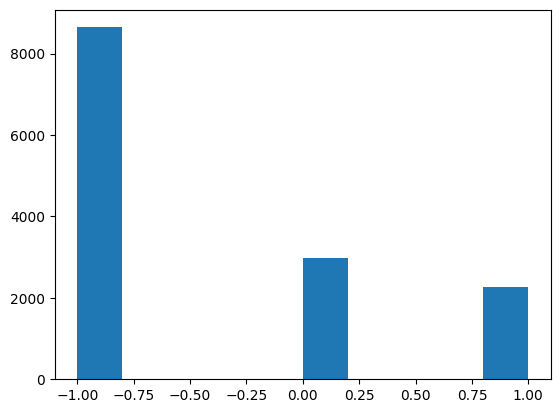

In [4]:
plt.hist(df.Sentiment);

In [5]:
# Specific lists of stopwords for this task
aircompanies_accounts = ['VirginAmerica', 'United', 'SouthwestAir', 'JetBlue', 
                         'Delta', 'USAirways', 'AmericanAir']
other_stopwords = ['fly', 'flying', 'flight', 'flights', 'plane']

eng_stopwords = stopwords.words('english')
eng_stopwords.extend([w.lower() for w in aircompanies_accounts])
eng_stopwords.extend(other_stopwords)

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
def my_tokenizer(tweet):
    # Remove everything but letters:
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    # Make lower-case:
    tweet = tweet.lower()
    # Tokenize tweet:
    tokens = nltk.word_tokenize(tweet)
    # Remove stop-words:
    tokens = list(filter(lambda token: token not in eng_stopwords, tokens))
    # Lemmatize all tokens:
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [8]:
tweet = df.Tweet[0]
print('Original tweet:\n',tweet)
print('\nTokenized tweet:\n',my_tokenizer(tweet))

Original tweet:
 @SouthwestAir good thing we noticed because she had re-routed 7 total passengers on an impossible triple connection as well

Tokenized tweet:
 good thing noticed routed total passenger impossible triple connection well


In [9]:
df['Tokens'] = df.apply(lambda x: my_tokenizer(x['Tweet']), axis=1)
df

,Sentiment,Tweet,Tokens
0,-1,@SouthwestAir good thing we noticed because sh...,good thing noticed routed total passenger impo...
1,1,@united They let us know in advance of the reb...,let u know advance reboot yes thanks attentive...
2,-1,"@USAirways sucks. Delayed my mom's flight 2X, ...",suck delayed mom x cancelled flightled delayed...
3,-1,@united can you DM me? Been on hold with custo...,dm hold customer service long time min getting...
4,1,@AmericanAir THANK YOU FOR ALL THE HELP! :P Y...,thank help p guy best americanairlines
...,...,...,...
13874,0,@JetBlue with 3 kids and 11 days 340 + doesn't...,kid day work month advance
13875,1,"@AmericanAir LTALJX, from DCA to OMA this morn...",ltaljx dca oma morning staff helped fix proble...
13876,-1,@AmericanAir I can't work with them if the cal...,work call get cut still holding dfw looking be...
13877,-1,@AmericanAir 2 months and still no exec platin...,month still exec platinum member card give


In [10]:
# Convert a collection of text documents to a matrix of binary token counts.
vectorizer_bernoulli = CountVectorizer(binary=True)
matrix_bernoulli = vectorizer_bernoulli.fit_transform(df['Tokens']).toarray()

In [11]:
matrix_bernoulli.shape

(13879, 12120)

In [12]:
(matrix_bernoulli == 0).mean()

0.9993227237198826

In [13]:
print(f'{matrix_bernoulli.max()=}')

matrix_bernoulli.max()=1


In [14]:
x_bern_train, x_bern_test, y_train, y_test \
    = train_test_split(matrix_bernoulli, df['Sentiment'].values, 
                       test_size = 0.2, random_state = 42)

In [15]:
nb_bernoulli = BernoulliNB()
nb_bernoulli.fit(x_bern_train, y_train)
print(f'{nb_bernoulli.score(x_bern_test, y_test)=}')

nb_bernoulli.score(x_bern_test, y_test)=0.7280259365994236


In [16]:
bern_proba = nb_bernoulli.predict_proba(x_bern_test)
bern_proba

array([[8.26295932e-01, 1.27379221e-01, 4.63248468e-02],
       [9.94291424e-01, 5.69626729e-03, 1.23083279e-05],
       [9.99325267e-01, 1.14461934e-04, 5.60270751e-04],
       ...,
       [8.58490984e-01, 1.37606732e-01, 3.90228486e-03],
       [9.99996924e-01, 2.80068295e-06, 2.75157050e-07],
       [9.99964006e-01, 1.02812613e-05, 2.57130901e-05]])

In [17]:
bern_proba /= bern_proba.sum(axis=1)[..., np.newaxis]
print(f'{log_loss(y_test, bern_proba)=}')

log_loss(y_test, bern_proba)=0.8543993371176791


In [18]:
y = df['Sentiment'].values

nb_bernoulli = BernoulliNB()
nb_bernoulli.fit(matrix_bernoulli, y)

BernoulliNB()

In [20]:
dump(nb_bernoulli, 'models/nb_bernoulli.joblib')
dump(vectorizer_bernoulli, 'models/vectorizer_bernoulli.joblib')

['models/vectorizer_bernoulli.joblib']